  status funds_code        amount    id customer_reference    bank_reference  \
0      D       None  -5000.00 AUD  F803   Payer Name This   0802198032003412   
1      D       None  -8000.00 AUD  F817   Payee Name This   0802198171413245   
2      D       None   -780.00 AUD  F870   2413480 07 Feb 2  0802198701413245   
3      D       None  -4000.00 AUD  F874   2413481 07 Feb 2  0802198741413245   
4      C       None   6000.00 AUD  F886   Payee Name This   0802198862056575   
5      C       None   5000.00 AUD  F887   Payer Name This   0802198872003412   
6      C       None   5000.00 AUD  F891   1286995 05 Feb 2  0802198911413245   
7      C       None   8000.00 AUD  F892   1286995 05 Feb 2  0802198921413245   
8      C       None   5000.00 AUD  F895   2003412 07 Feb 2  0802198951413245   
9      C       None   8000.00 AUD  F896   5642137 07 Feb 2  0802198961413245   

                extra_details currency        date  entry_date  \
0  is the beneficiary descrip      AUD  2019-02-08  2

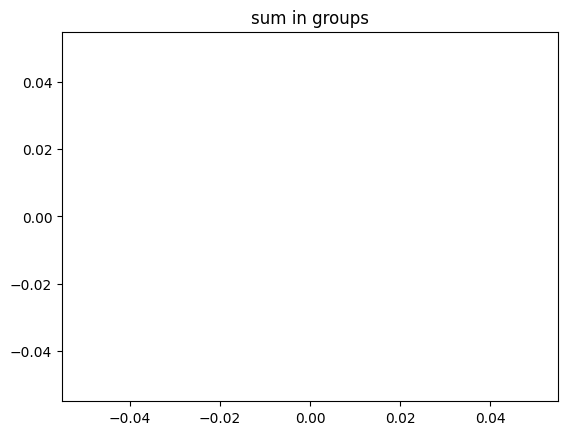

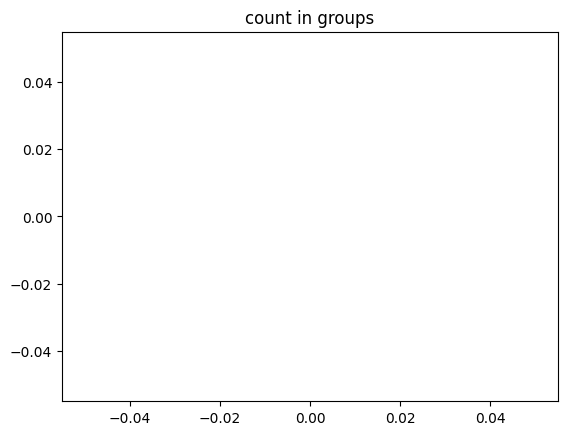

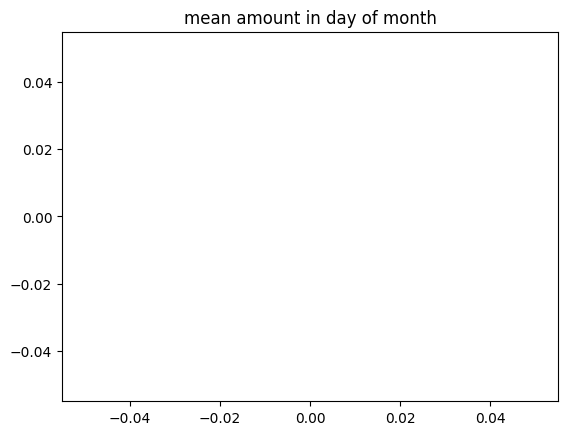

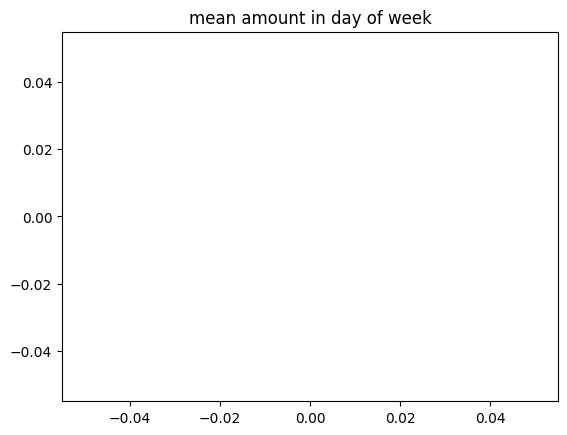

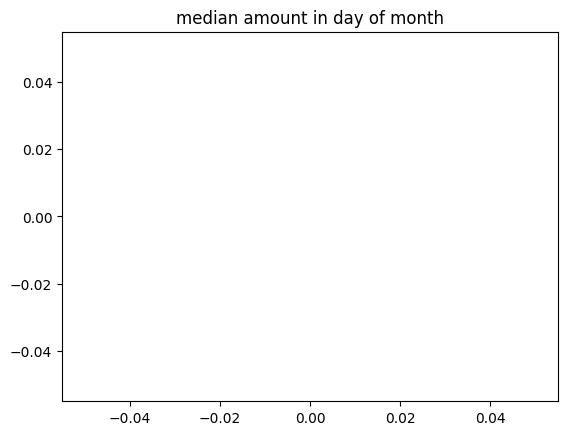

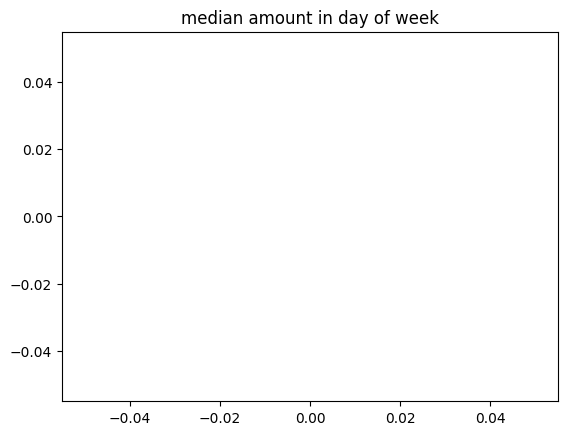

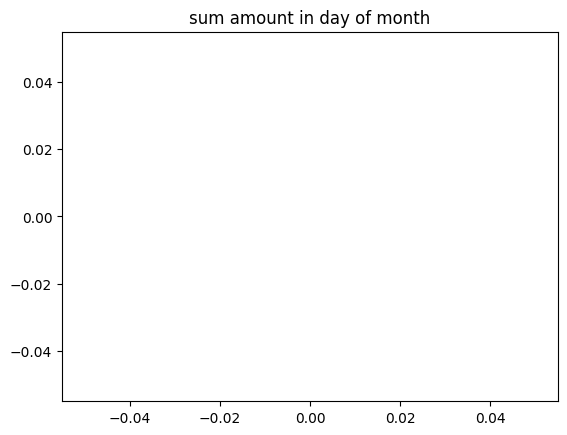

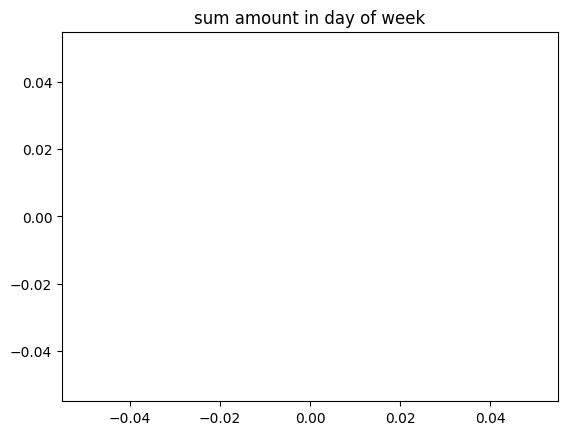

In [7]:
#test file downlaoded from https://bankrec.westpac.com.au/docs/statements/mt940/

import mt940
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

#function for loading data from files
def loadFromFiles():
    transactionFiles=[]
    input=[]
    for fn in os.listdir('mt940'):
        transactionFiles.append(mt940.parse('mt940/'+fn))

    for tf in transactionFiles:
        for t in tf:
            input.append(t.data)
    return pd.DataFrame(input)

#prepare data for analysis, delete unnecessary data, split columns
def prepareData(df, currency):
    df=df.copy()
    #converting columns types
    df['amount']=df['amount'].apply(lambda x:pd.to_numeric(x.amount))
    df['date']=df['date'].apply(lambda x:pd.to_datetime(str(x)))
    df=df.convert_dtypes()
    #select only payments
    df=df[df['amount']<0]
    df['amount']=df['amount'].apply(np.abs)
    #select only specyfic currency
    df=df[df['currency']==currency]
    df['transaction_details']=df['transaction_details'].apply(lambda x:(" ".join(x.split())).replace('\n',''))
    df['title']=df['transaction_details'].str.extract('~20(.*?)~')
    df['contractor']=df['transaction_details'].str.extract('~32(.*?)~')
    df['contractor']=df['contractor'].str.lower()
    df['day_of_month']=df['date'].apply(lambda x: x.day)
    df['day_of_week']=df['date'].apply(lambda x: x.weekday())
    df['account']=df['transaction_details'].str.extract('~38(.*?)$')
    #deleting unnecessary columns
    del df['bank_reference']
    del df['extra_details']
    del df['id']
    del df['funds_code']
    del df['entry_date']
    del df['guessed_entry_date']
    del df['customer_reference']
    del df['status']
    del df['currency']
    return df

def crateAmountGroups(x):
    amount=x['amount']
    if(amount<10):
        return '<10'
    if(amount<20):
        return '<20'
    if(amount<40):
        return '<40'
    if(amount<80):
        return '<80'
    if(amount<160):
        return '<160'
    if(amount<320):
        return '<320'
    if(amount<640):
        return '<640'
    if(amount<1280):
        return '<1280'
    if(amount>1280):
        return '>1280'

df=loadFromFiles()
df=prepareData(df, 'PLN')

#remove data by account some transactions are inner
df=df[df['account']!='account_number']
df['group']=df.apply(crateAmountGroups, axis=1)

df2=df.groupby('group').sum('amount')
df2=df2.sort_values(by='amount', ascending=False)
names=[e.name for e in df2.iloc]
plt.title('sum in groups')
plt.bar(names, df2['amount'])

plt.figure()
df2=df.groupby('group').count()
df2=df2.sort_values(by='amount', ascending=False)
names=[e.name for e in df2.iloc]
plt.title('count in groups')
plt.bar(names, df2['amount'])

plt.figure()
df2=df.groupby('day_of_month').mean('amount')
names=[e.name for e in df2.iloc]
plt.title('mean amount in day of month')
plt.bar(names, df2['amount'])

plt.figure()
df2=df.groupby('day_of_week').mean('amount')
names=[e.name for e in df2.iloc]
plt.title('mean amount in day of week')
plt.bar(names, df2['amount'])
plt.figure()

df2=df.groupby('day_of_month').median('amount')
names=[e.name for e in df2.iloc]
plt.title('median amount in day of month')
plt.bar(names, df2['amount'])

plt.figure()
df2=df.groupby('day_of_week').median('amount')
names=[e.name for e in df2.iloc]
plt.title('median amount in day of week')
plt.bar(names, df2['amount'])

plt.figure()
df2=df.groupby('day_of_month').sum('amount')
names=[e.name for e in df2.iloc]
plt.title('sum amount in day of month')
plt.bar(names, df2['amount'])

plt.figure()
df2=df.groupby('day_of_week').sum('amount')
names=[e.name for e in df2.iloc]
plt.title('sum amount in day of week')
plt.bar(names, df2['amount'])

print('Total payments',df['amount'].sum())